In [15]:
import pickle
import joblib
import sklearn
import random
import os
import pandas as pd
import numpy as np

from magic_loop import load_transformation, filter_drop, \
                                      transformation_pipeline, train_test_split, NUM_VARS, CAT_VARS

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [3]:
sklearn.__version__

'0.20.2'

In [4]:
joblib.__version__

'0.14.0'

Los siguientes promedios se calcularon de forma separada y se muestra aquí únicamente la cifra con fines de simplificar el análisis. 

In [5]:
ambulancias_disponibles_al_dia = 20.0
num_llamadas_al_dia = 550.0

In [6]:
path = os.getcwd()
path

'/Users/enriqueortiz/Documents/PROJECTS/proyecto_ambulancias/notebooks_pers'

In [7]:
df = load_transformation(path)

Opening feature engineering pickle from output path
Feature Engineering pickle successfully retrieved.


In [103]:
# Load all X_train, y_train, X_test, y test
X_train = pickle.load(open("X_train_diciembre4.pkl", 'rb'))
y_train = pickle.load(open("Y_train_diciembre4.pkl", 'rb'))
X_test = pickle.load(open("X_test_diciembre4.pkl", 'rb'))
y_test = pickle.load(open("y_test_diciembre4.pkl", 'rb'))

In [104]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(967884, 62) (967884,) (414808, 62) (414808,)


# Regresión Logística

En experimentos internos descubrimos que tanto el modelo _RandomForestClassifier_ como el _DecisionTree_ nos dieron resultados relativamente deficientes en prácticamente todas las métricas relevantes, por lo que intentamos usar Regresión Logística. 

In [105]:
logreg = LogisticRegression()

In [106]:
#realmente la falta de tiempo nos impidió probar más combinaciones 
grid_params = {'penalty': ['l2'],
              'solver': ['sag', 'saga']}

In [107]:
#toma como 7 min; no es tanto (vs. los 90 min de un Random Forrest Gump)
tscv = TimeSeriesSplit(n_splits=5)
gs = GridSearchCV(logreg, grid_params, scoring='precision', cv = tscv,
                          n_jobs = -1)

gs.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l2'], 'solver': ['sag', 'saga']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=0)

In [108]:
model = gs.best_estimator_
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [109]:
# predicciones con el mejor predictor 
predicted_labels = model.predict(X_test)

In [110]:
predicted_labels.shape

(414808,)

In [111]:
# predicciones en score con el mejor predictor
predicted_scores = model.predict_proba(X_test)

In [112]:
predicted_scores.shape

(414808, 2)

In [113]:
predicted_probs = pd.DataFrame(predicted_scores, columns=["probability_0", "probability_1"])
predicted_probs.head()

,probability_0,probability_1
0,0.751344,0.248656
1,0.733748,0.266252
2,0.847479,0.152521
3,0.733748,0.266252
4,0.714488,0.285512


## ROC

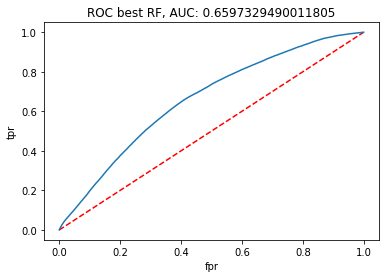

In [114]:
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

%matplotlib inline

fpr, tpr, thresholds = roc_curve(y_test, predicted_probs.probability_1, pos_label=1)

plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
#aquí abajo van las probabilidades, no el label 
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_probs.probability_1)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show();

## Matriz de confusión

In [115]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(y_test, predicted_labels))
#columnas = tu predicción
#renglones = la realidad

,0,1
0,333679,196
1,80747,186


## Precision, recall, thresholds

In [116]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_probs.probability_1, pos_label=1)

In [117]:
thresholds_2 = np.append(thresholds_2, 1)

In [118]:
(precision.shape, recall.shape, thresholds_2.shape)

((346712,), (346712,), (346712,))

In [119]:
from sklearn.metrics import precision_score

def precision_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*(len(y_scores)-1))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return precision_score(y_true, y_pred)

In [120]:
from sklearn.metrics import recall_score
def recall_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*(len(y_scores)-1))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return recall_score(y_true, y_pred)

In [121]:
def get_top_k(y_scores, k):
    pass

In [122]:
def pr_k_curve(y_true, y_scores, save_target=None):
    k_values = list(np.arange(0.1, 1.1, 0.1))
    pr_k = pd.DataFrame()

    for k in k_values:
        d = dict()
        d['k'] = k
        ## get_top_k es una función que ordena los scores de
        ## mayor a menor y toma los k% primeros
        #top_k = get_top_k(y_scores, k)
        #top_k = y_scores
        # print(precision_at_k(y_true, y_scores, k))
        d['precision'] = precision_at_k(y_true, y_scores, k)#(top_k)
        d['recall'] = recall_at_k(y_true, y_scores, k)#(top_k, predictions)

        pr_k = pr_k.append(d, ignore_index=True)

    # para la gráfica
    fig, ax1 = plt.subplots()
    ax1.plot(pr_k['k'], pr_k['precision'], label='precision')
    ax1.plot(pr_k['k'], pr_k['recall'], label='recall')
    plt.legend()

    if save_target is not None:
        plt.savefig(save_target, dpi=300)
    else:
        plt.show

    return pr_k

In [123]:
k = ambulancias_disponibles_al_dia/num_llamadas_al_dia
precision_at_k(predicted_labels, y_test, k)

0.0022981972742886093

In [124]:
precision_at_k(y_test, predicted_labels, k)

0.19510954465680508

In [125]:
set(y_test) - set(predicted_labels)

set()

In [126]:
recall_at_k(predicted_labels, y_test, k)

0.4869109947643979

,k,precision,recall
0,0.1,0.002298,0.486911
1,0.2,0.000921,1.000000
2,0.3,0.000921,1.000000
3,0.4,0.000921,1.000000
4,0.5,0.000921,1.000000
5,0.6,0.000921,1.000000
6,0.7,0.000921,1.000000
7,0.8,0.000921,1.000000
8,0.9,0.000921,1.000000
9,1.0,0.000921,1.000000


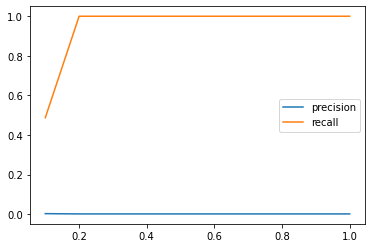

In [128]:
pr_k_curve(predicted_labels, y_test)

## Reporte de métricas

In [129]:
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2,'precision': precision,
                    'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
    
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
    
    df = df_1.merge(df_2, on="threshold")
    
    return df

In [130]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.007078,0.195157,1.000000,0.326579,1.000000,0.999700,0.000300,0.000000
1,0.007097,0.195155,0.999988,0.326576,0.999988,0.999700,0.000300,0.000012
2,0.008386,0.195196,0.999988,0.326633,0.999988,0.999440,0.000560,0.000012
3,0.008409,0.195192,0.999963,0.326626,0.999963,0.999440,0.000560,0.000037
4,0.008546,0.195199,0.999963,0.326636,0.999963,0.999395,0.000605,0.000037
...,...,...,...,...,...,...,...,...
172595,0.667655,0.888889,0.000198,0.000395,0.000198,0.000006,0.999994,0.999802
172596,0.670906,0.941176,0.000198,0.000395,0.000198,0.000003,0.999997,0.999802
172597,0.671876,0.937500,0.000185,0.000371,0.000185,0.000003,0.999997,0.999815
172598,0.675174,1.000000,0.000185,0.000371,0.000185,0.000000,1.000000,0.999815


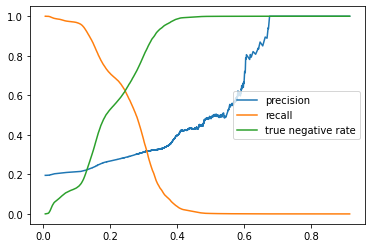

In [132]:
plt.plot(metrics_report.threshold, metrics_report.precision, label="precision")
plt.plot(metrics_report.threshold, metrics_report.recall, label="recall")
plt.plot(metrics_report.threshold, metrics_report.tnr, label="true negative rate")
plt.legend(loc="best")
plt.show();

¿Qué métrica escogemos?

TP = El modelo dice que es llamada falsa,    y sí es llamada falsa

TN = El modelo dice que es llamada no falsa, y no es llamada falsa**

FP = El modelo dice que es llamada falsa,    y no es llamada falsa

FN = El modelo dice que es llamada no falsa,   y sí es llamada falsa

Decidimos TNR dado que nos interesa ayudar verificar que una llamada que el modelo dice que no es falsa, realmente no es falsa, ya que probablemente se necesite enviar una ambulancia.

De acuerdo a las métricas del negocio, les interesa tener un TNR mayor al 80%. Es decir, de 10 llamadas que el modelo dice que son llamadas legítimas, por lo menos 8 deben ser realmente legítimas.

In [80]:
negocio = metrics_report[metrics_report.tnr >= 0.8]

In [81]:
negocio

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
117887,0.290330,0.303302,0.359186,0.328887,0.359186,0.200000,0.800000,0.640814
117888,0.290332,0.303309,0.359186,0.328891,0.359186,0.199994,0.800006,0.640814
117889,0.290333,0.303321,0.359186,0.328898,0.359186,0.199982,0.800018,0.640814
117890,0.290333,0.303324,0.359186,0.328900,0.359186,0.199979,0.800021,0.640814
117891,0.290333,0.303317,0.359174,0.328891,0.359174,0.199979,0.800021,0.640826
...,...,...,...,...,...,...,...,...
151835,0.441980,0.250000,0.000025,0.000049,0.000025,0.000018,0.999982,0.999975
151836,0.443368,0.142857,0.000012,0.000025,0.000012,0.000018,0.999982,0.999988
151837,0.443369,0.166667,0.000012,0.000025,0.000012,0.000015,0.999985,0.999988
151838,0.446640,0.000000,0.000000,NaN,0.000000,0.000009,0.999991,1.000000


Matriz asociada a este punto de corte

In [94]:
punto_corte = negocio.head(1).threshold.values[0]
punto_corte = .32

In [95]:
new_labels = [0 if score < punto_corte else 1 for score in predicted_probs.probability_1]

In [96]:
pd.Series(new_labels).sum()

39033

En la siguiente matriz de confusión podemos ver que con el nuevo punto de corte generamos más Falsos Positivo.

Columnas = Predicción

Renglones = Groundtruth

In [101]:
len(y_train)

967884

In [97]:
pd.DataFrame(confusion_matrix(y_test, new_labels))

,0,1
0,307238,26637
1,68537,12396


Matriz de confusión original:

In [98]:
pd.DataFrame(confusion_matrix(y_test, predicted_labels))

,0,1
0,333875,0
1,80933,0
